# Smoke Detection Dataset

## Summary

#### This project has used Arduino Nicla Sense ME as a system to detect and collect data

Context
A smoke detector is a device that senses smoke, typically as an indicator of fire. Smoke detectors are usually housed in plastic enclosures, typically shaped like a disk about 150 millimetres (6 in) in diameter and 25 millimetres (1 in) thick, but shape and size vary.

--> Types of Smoke Detectors

Photoelectric Smoke Detector
A photoelectric smoke detector contains a source of infrared, visible, or ultraviolet light, a lens, and a photoelectric receiver. In some types, the light emitted by the light source passes through the air being tested and reaches the photosensor. The received light intensity will be reduced due to scattering from particles of smoke, air-borne dust, or other substances; the circuitry detects the light intensity and generates an alarm if it is below a specified threshold, potentially due to smoke. Such detectors are also known as optical detectors.

Ionization Smoke Detector
An ionization smoke detector uses a radioisotope to ionize air. If any smoke particles enter the open chamber, some of the ions will attach to the particles and not be available to carry the current in that chamber. An electronic circuit detects that a current difference has developed between the open and sealed chambers, and sounds the alarm

The author of this dataset has successfully created a smoke detection device with the help of IOT devices and AI model. (Check Acknowledgement )

About the dataset
Collection of training data is performed with the help of IOT devices since the goal is to develop a AI based smoke detector device.
Many different environments and fire sources have to be sampled to ensure a good dataset for training. A short list of different scenarios which are captured:

Normal indoor
Normal outdoor
Indoor wood fire, firefighter training area
Indoor gas fire, firefighter training area
Outdoor wood, coal, and gas grill
Outdoor high humidity
etc.
The dataset is nearly 60.000 readings long. The sample rate is 1Hz for all sensors. To keep track of the data, a UTC timestamp is added to every sensor reading.

# Imports

In [5]:
import re
import copy
import kaggle
from zipfile import ZipFile

import numpy as np
import pandas as pd


OSError: Could not find kaggle.json. Make sure it's located in C:\Users\viniciushc\.kaggle. Or use the environment method.

In [2]:

from scipy import stats
from patsy import dmatrices
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from kaggle.api.kaggle_api_extended import KaggleApi

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

OSError: Could not find kaggle.json. Make sure it's located in C:\Users\viniciushc\.kaggle. Or use the environment method.

In [3]:
# !kaggle datasets download -d deepcontractor/smoke-detection-dataset

# Get Data

In [4]:
api = KaggleApi()
api.authenticate()
api.dataset_download_file('deepcontractor/smoke-detection-dataset', 'smoke_detection_iot.csv', path=r'C:\Users\viniciushc\Git_Vinicius\fire_alarm\data')

False

In [5]:
with ZipFile(r'C:\Users\viniciushc\Git_Vinicius\fire_alarm\data\smoke_detection_iot.csv.zip', 'r') as zip_file:
    zip_file.extractall(
        r'C:\Users\viniciushc\Git_Vinicius\fire_alarm\data'
    )

# Reading Data

In [6]:
df_raw_smokedata = pd.read_csv(r'C:\Users\viniciushc\Git_Vinicius\fire_alarm\data\smoke_detection_iot.csv')

In [7]:
df_raw_smokedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


## Removing Index and CNT columns

* Removing Index Column because isn't needed
* Removing CNT column because SAMPLE COUNTER doesn't aggregate anything at all

In [8]:
df_raw_smokedata.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


In [9]:
df_raw_smokedata.drop(['Unnamed: 0', 'CNT'], axis=1, inplace=True)

## Renaming Columns

In [10]:
new_columns = [
    re.sub('\[.*?]', '', new_name).lower().replace(' ', '_')
    for new_name in df_raw_smokedata.columns
    ]

In [11]:
df_raw_smokedata.columns = new_columns
df_raw_smokedata.head()

,utc,temperature,humidity,tvoc,eco2,raw_h2,raw_ethanol,pressure,pm1.0,pm2.5,nc0.5,nc1.0,nc2.5,fire_alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0


In [12]:
# There is no null data
df_raw_smokedata.isnull().sum()

utc            0
temperature    0
humidity       0
tvoc           0
eco2           0
raw_h2         0
raw_ethanol    0
pressure       0
pm1.0          0
pm2.5          0
nc0.5          0
nc1.0          0
nc2.5          0
fire_alarm     0
dtype: int64

In [13]:
# Transforming UTC timestamp to datetime format
df_raw_smokedata['date'] = df_raw_smokedata['utc'].apply(lambda x: datetime.fromtimestamp(x).strftime("%Y-%m-%d"))
df_raw_smokedata.head()

,utc,temperature,humidity,tvoc,eco2,raw_h2,raw_ethanol,pressure,pm1.0,pm2.5,nc0.5,nc1.0,nc2.5,fire_alarm,date
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,2022-06-08
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0,2022-06-08
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0,2022-06-08
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0,2022-06-08
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0,2022-06-08


# Exploratory Analysis

In [14]:
df_raw_smokedata.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]].describe()

,temperature,humidity,tvoc,eco2,raw_h2,raw_ethanol,pressure,pm1.0,pm2.5,nc0.5,nc1.0,nc2.5
count,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000
mean,15.970424,48.539499,1942.057528,670.021044,12942.453936,19754.257912,938.627649,100.594309,184.467770,491.463608,203.586487,80.049042
std,14.359576,8.865367,7811.589055,1905.885439,272.464305,609.513156,1.331344,922.524245,1976.305615,4265.661251,2214.738556,1083.383189
min,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.994250,47.530000,130.000000,400.000000,12830.000000,19435.000000,938.700000,1.280000,1.340000,8.820000,1.384000,0.033000
50%,20.130000,50.150000,981.000000,400.000000,12924.000000,19501.000000,938.816000,1.810000,1.880000,12.450000,1.943000,0.044000
75%,25.409500,53.240000,1189.000000,438.000000,13109.000000,20078.000000,939.418000,2.090000,2.180000,14.420000,2.249000,0.051000
max,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000


We can observe that median and mean values of humidity, hydrogens, ethanol, and pressure are nearly close. Which means that could be a distribution of data closely to a normal distribution.

In [15]:
(
    df_raw_smokedata.groupby(['fire_alarm'])
        .mean()
        .sort_values(by='fire_alarm', ascending=False)
)

,utc,temperature,humidity,tvoc,eco2,raw_h2,raw_ethanol,pressure,pm1.0,pm2.5,nc0.5,nc1.0,nc2.5
fire_alarm,,,,,,,,,,,,,
1,1.654765e+09,14.483152,50.779534,882.013071,553.189356,12960.878053,19623.050428,938.837806,36.146406,78.417842,146.111337,87.665549,40.541627
0,1.654860e+09,19.694803,42.930077,4596.587255,962.587255,12896.316847,20082.823533,938.101383,261.982706,450.034639,1356.283816,493.872027,178.982259


All means showed in the cell above could represent some interval between the sample that a fire was observed or not

In [16]:
pd.pivot_table(
    df_raw_smokedata,
    values=['raw_ethanol', 'temperature', 'humidity', 'eco2'],
    index='fire_alarm',
    aggfunc=['mean', 'count', 'median'],
    margins=True
)

mean                                       count           \
                  eco2   humidity   raw_ethanol temperature   eco2 humidity   
fire_alarm                                                                    
0           962.587255  42.930077  20082.823533   19.694803  17873    17873   
1           553.189356  50.779534  19623.050428   14.483152  44757    44757   
All         670.021044  48.539499  19754.257912   15.970424  62630    62630   

                                   median                                   
           raw_ethanol temperature   eco2 humidity raw_ethanol temperature  
fire_alarm                                                                  
0                17873       17873    400    46.14       20158       20.54  
1                44757       44757    404    51.40       19454       20.02  
All              62630       62630    400    50.15       19501       20.13

In [17]:
df_raw_smokedata[['humidity', 'eco2', 'raw_ethanol', 'pressure']].aggregate(['min', 'mean', 'median', 'max']).T.round(2)

,min,mean,median,max
humidity,10.74,48.54,50.15,75.20
eco2,400.00,670.02,400.00,60000.00
raw_ethanol,15317.00,19754.26,19501.00,21410.00
pressure,930.85,938.63,938.82,939.86


In [18]:
df_raw_smokedata['temp_interval'] = pd.cut(df_raw_smokedata['temperature'], bins=4)
df_raw_smokedata

,utc,temperature,humidity,tvoc,eco2,raw_h2,raw_ethanol,pressure,pm1.0,pm2.5,nc0.5,nc1.0,nc2.5,fire_alarm,date,temp_interval
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,2022-06-08,"(18.96, 39.445]"
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,0,2022-06-08,"(18.96, 39.445]"
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,0,2022-06-08,"(18.96, 39.445]"
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,0,2022-06-08,"(18.96, 39.445]"
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,0,2022-06-08,"(18.96, 39.445]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,0,2022-06-13,"(-1.525, 18.96]"
62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,0,2022-06-13,"(-1.525, 18.96]"
62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,0,2022-06-13,"(-1.525, 18.96]"
62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,0,2022-06-13,"(18.96, 39.445]"


## Statistical Test

In [19]:
y, X = dmatrices('fire_alarm ~ temperature + humidity + tvoc + eco2 + raw_h2', data=df_raw_smokedata, return_type='dataframe')

In [20]:
result = sm.OLS(y, X).fit()
print(result.params)
print(result.summary())
print(result.pvalues)

Intercept     -1.056787
temperature   -0.002159
humidity       0.019564
tvoc          -0.000004
eco2           0.000028
raw_h2         0.000065
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             fire_alarm   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     2602.
Date:                Mon, 26 Sep 2022   Prob (F-statistic):               0.00
Time:                        20:13:37   Log-Likelihood:                -33169.
No. Observations:               62630   AIC:                         6.635e+04
Df Residuals:                   62624   BIC:                         6.640e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P

In [21]:
no_fire_data_proportion = df_raw_smokedata[df_raw_smokedata['fire_alarm'] == 1].shape[0] / df_raw_smokedata.shape[0]

print(f'Fire alarm proportion data: {round(no_fire_data_proportion * 100, 3)}%')
print(f'No fire alarm proportion data: {round((1 - no_fire_data_proportion) * 100, 3)}%')

Fire alarm proportion data: 71.463%
No fire alarm proportion data: 28.537%


In [22]:
def teste(col):
    mu = df_raw_smokedata[col].mean()
    n = df_raw_smokedata.shape[0]
    variance = np.sum([(var - mu)**2 for var in df_raw_smokedata[col]]) / n
    sigma = np.sqrt(variance)
    print("Variable = ", col)
    print("Mean = ", mu)
    print("Variance = ", variance)
    print("Sigma = ", sigma)
    print("########################")

In [ ]:
for col in df_raw_smokedata.columns:
    teste(col)

In [27]:
df_raw_smokedata['date'].unique()

array(['2022-06-08', '2022-06-09', '2022-06-10', '2022-06-13'],
      dtype=object)

In [28]:
mu = df_raw_smokedata['temperature'].mean()
n = df_raw_smokedata.shape[0]
variance = np.sum([(var - mu)**2 for var in df_raw_smokedata['temperature']])
sigma = np.sqrt(variance)
sigma

3593.5968991087148

In [29]:
SE = sigma / np.sqrt(n)
SE

14.359461513991358

In [30]:
n = df_raw_smokedata['fire_alarm'].shape[0]
mu_bin = n * no_fire_data_proportion
var_bin = n * no_fire_data_proportion * (1 - no_fire_data_proportion)
sigma_bin = np.sqrt(var_bin)
sigma_bin

113.01549880358343

In [ ]:
for col in df_raw_smokedata.columns:
    plt.figure(figsize=(5, 3))
    df_raw_smokedata[col].hist(bins=50)
    plt.title(col)

### Mean Normalization

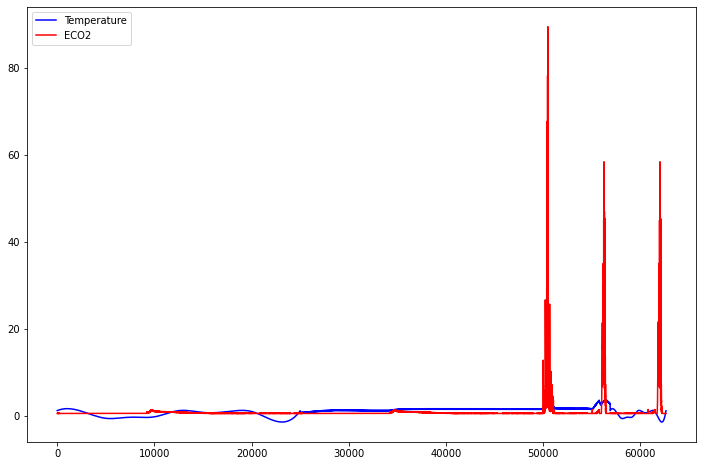

In [33]:
# TODO Data Normalization
x_temp = df_raw_smokedata['temperature'] / df_raw_smokedata['temperature'].mean()
x_eco = df_raw_smokedata['eco2'] / df_raw_smokedata['eco2'].mean()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(x_temp, 'b-', label = 'Temperature')

ax.plot(x_eco, 'r-', label = 'ECO2')
ax.legend(loc = 'upper left')
plt.show()

Text(0.5, 1.0, 'Probplot against normal distribution')

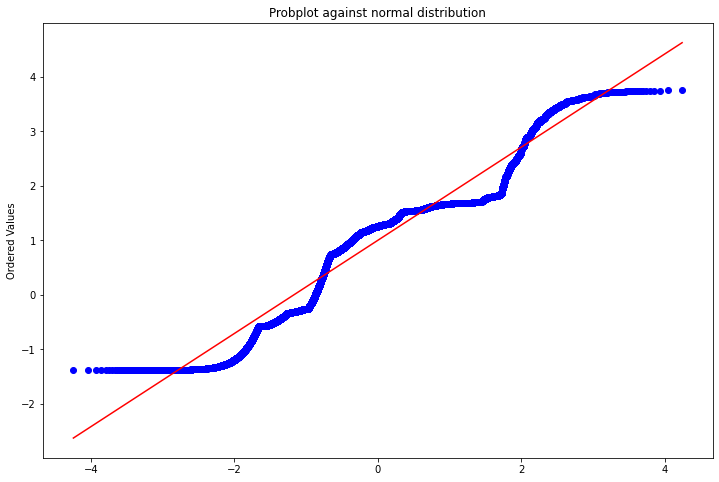

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
# x = stats.loggamma.rvs(5, size=500) + 5


In [36]:
x_temp_b = x_temp[x_temp > 0]

In [37]:
x_temp_box, lmbda = stats.boxcox(x_temp_b)
x_temp_box, lmbda

(array([0.2468103 , 0.24771024, 0.24855007, ..., 0.17845643, 0.19154644,
        0.20460839]),
 0.8103559786575315)

Text(0.5, 1.0, 'Boxcox probplot')

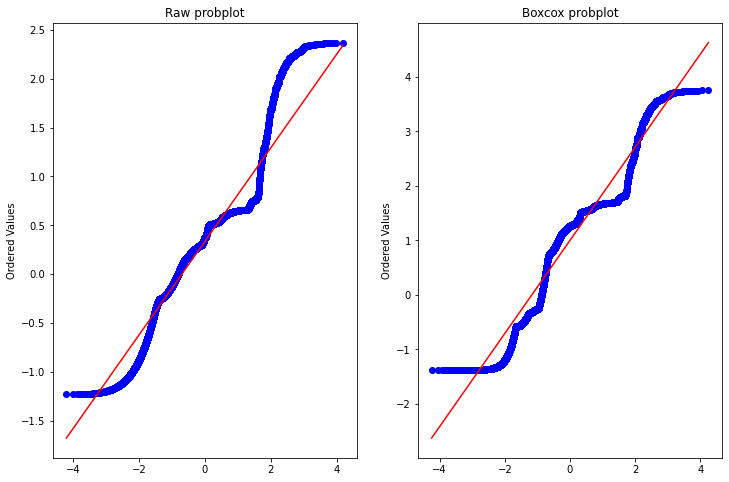

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

stats.probplot(x_temp_box, dist=stats.norm, plot=ax[0])
stats.probplot(x_temp, dist=stats.norm, plot=ax[1])

ax[0].set_xlabel('')
ax[0].set_title('Raw probplot')

ax[1].set_xlabel('')
ax[1].set_title('Boxcox probplot')


Text(0.5, 1.0, 'Boxcox dist')

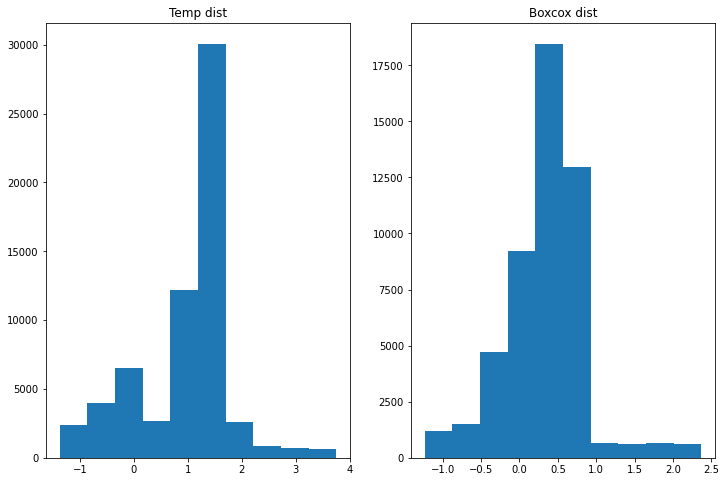

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].hist(x_temp)
ax[1].hist(x_temp_box)

ax[0].set_xlabel('')
ax[0].set_title('Temp dist')

ax[1].set_xlabel('')
ax[1].set_title('Boxcox dist')

c:\Users\viniciushc\Anaconda3\envs\house_prices\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\viniciushc\Anaconda3\envs\house_prices\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


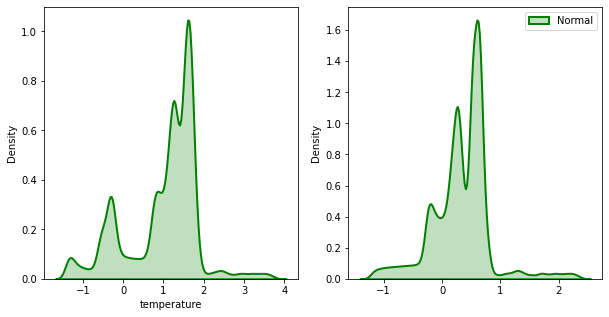

In [42]:
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)

sns.distplot(x_temp, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
  
sns.distplot(x_temp_box, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
  
# adding legends to the subplots
plt.legend(loc = "upper right")

# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)  

<AxesSubplot:xlabel='temperature', ylabel='eco2'>

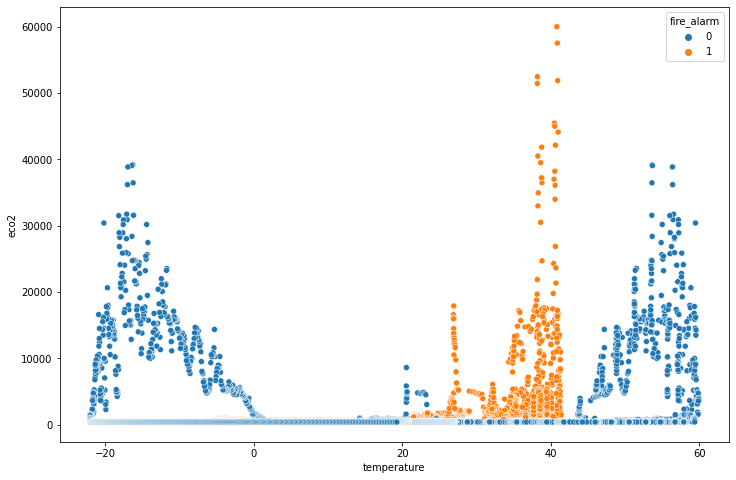

In [43]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data = df_raw_smokedata,
    x = 'temperature',
    y = 'eco2',
    hue = 'fire_alarm'
)

# Feature Selection

In [44]:
df_raw_smokedata_cols = df_raw_smokedata[
    [
    'temperature',
    'humidity',
    'tvoc',
    'eco2',
    'raw_h2',
    'raw_ethanol',
    'pressure',
    'pm1.0',
    'pm2.5',
    'nc0.5',
    'nc1.0',
    'nc2.5'
    ]
]

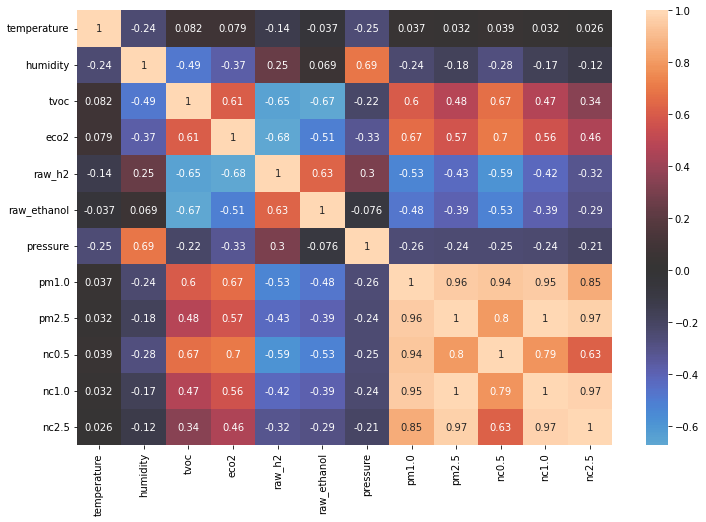

In [45]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_raw_smokedata_cols.corr(), annot=True, center=0.01, robust=True, linecolor='black', alpha=0.9)
plt.show()

In [47]:
# Data selected
df_raw_smokedata_input = df_raw_smokedata[
    [
    'temperature',
    'humidity',
    'tvoc',
    'eco2',
    'raw_h2',
    'raw_ethanol',
    'pressure',
    'fire_alarm'
    ]
]

# Train & Test Split

In [48]:
df_raw_smokedata_input.head()

,temperature,humidity,tvoc,eco2,raw_h2,raw_ethanol,pressure,fire_alarm
0,20.000,57.36,0,400,12306,18520,939.735,0
1,20.015,56.67,0,400,12345,18651,939.744,0
2,20.029,55.96,0,400,12374,18764,939.738,0
3,20.044,55.28,0,400,12390,18849,939.736,0
4,20.059,54.69,0,400,12403,18921,939.744,0


In [49]:
X = df_raw_smokedata_input.iloc[:, :-1]
y = df_raw_smokedata_input.iloc[:, -1]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=int(np.cbrt(74088)))

In [51]:
print(f'X_train size = {X_train.shape}\nX_test size = {X_test.shape}\ny_train size = {y_train.shape}\ny_test size = {y_test.shape}')

X_train size = (50104, 7)
X_test size = (12526, 7)
y_train size = (50104,)
y_test size = (12526,)


# Logistic Regression from Scikit-learn

In [52]:
clf = LogisticRegression(
    max_iter=10000,
    penalty='l2',
    solver='newton-cg',
    multi_class='auto',
    # n_jobs=-1,
    random_state=int(np.cbrt(74088))).fit(X_train, y_train)

c:\Users\viniciushc\Anaconda3\envs\house_prices\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\viniciushc\Anaconda3\envs\house_prices\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\viniciushc\Anaconda3\envs\house_prices\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [57]:
predict = clf.predict(X_test)
clf.predict_proba(X_test)

array([[6.58355705e-01, 3.41644295e-01],
       [2.08753833e-03, 9.97912462e-01],
       [9.99998929e-01, 1.07109131e-06],
       ...,
       [5.08239639e-02, 9.49176036e-01],
       [9.99987474e-01, 1.25258211e-05],
       [7.03866175e-03, 9.92961338e-01]])

In [59]:
score = clf.score(X_test, y_test)

In [55]:
x = np.array(df_raw_smokedata[['temperature', 'humidity']].loc[0])
x

array([20.  , 57.36])

In [56]:
from sklearn import metrics

In [58]:
cm = metrics.confusion_matrix(y_test, predict)
print(cm)

[[2731  863]
 [ 469 8463]]


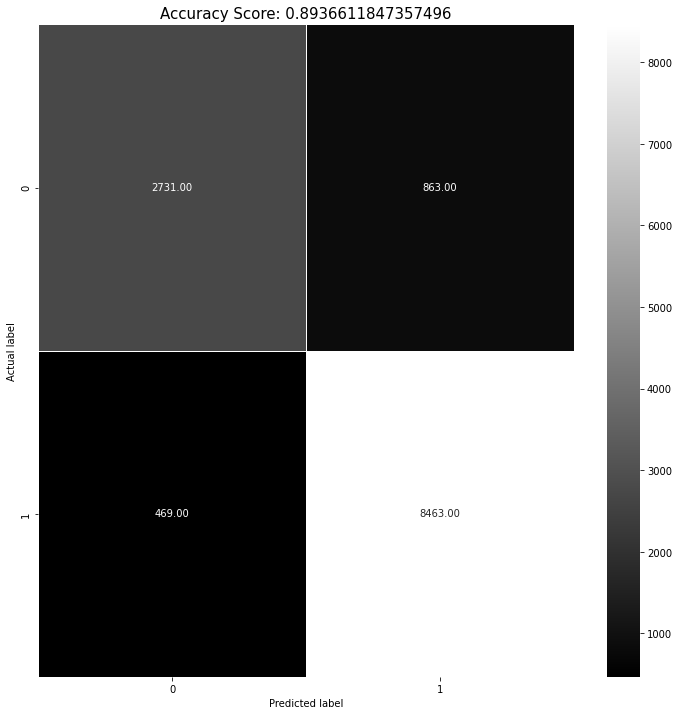

In [79]:
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, cmap='gist_yarg_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

# Homemade Logistic Regression

### TODO:

In [ ]:
def sigmoid(z):

    s = 1 / (1 + (np.exp(-z)))
        
    return s

In [ ]:
def initialize_with_zeros(dim):

    w = np.zeros((dim, 1))
    b = 0.0    

    return w, b

In [ ]:
def propagate(w, b, X, Y):
    
    m = X.shape[1]
    print('Shape m', m)
    
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -1/m*np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))

    dw = 1./m*np.dot(X, (A-Y).T)
    db = 1./m*np.sum(A-Y)

    cost = np.squeeze(np.array(cost))

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [ ]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost =propagate(w, b, X, Y)

        dw = grads["dw"]
        db = grads["db"]
        

        w = w - learning_rate * dw
        b = b - learning_rate * db

        if i % 100 == 0:
            costs.append(cost)
        
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [ ]:
def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A =   sigmoid(np.dot(w.T, X) + b)

    for i in range(A.shape[1]):

        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
             Y_prediction[0, i] = 0
    
    return Y_prediction